# GANs

Will create a standard GAN and a DCGAN on the MNIST dataset to try to generate numerical digits.

</br>

## Import Data and Libraries
---

In [646]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader

In [647]:
BATCH_SIZE = 32
LEARNING_RATE = 3e-4
EPOCHS = 100
TEST_SIZE = 0.35
INPUT_DIM = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [648]:
data = pd.read_csv("sample_data/mnist_train_small.csv", header=None)
X = data.drop(columns=[0])
y = data[0]

X.shape, y.shape

((20000, 784), (20000,))

</br></br>

Plot a sample of the MNIST dataset

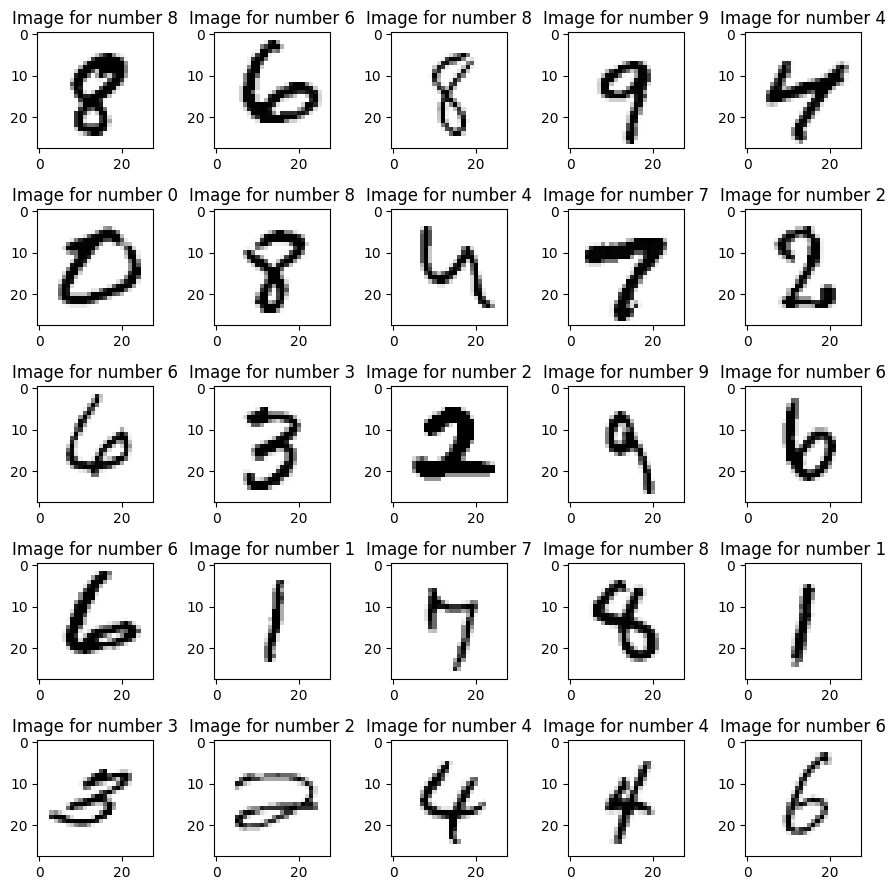

In [649]:
plt.figure(figsize=(9, 9))
for i in range(25):
  idx = torch.randint(0, X.shape[1], (1,)).item()
  plt.subplot(5, 5, i + 1)
  plt.imshow(X.iloc[idx].values.reshape((28, 28)), cmap='Greys')
  plt.title(f"Image for number {y[idx]}");

plt.tight_layout()

</br></br>
## Preprocess Dataset
---
</br></br>
Create the DataLoaders for the MNIST dataset that will shuffle and batch the data, and normalize the images so that the values are between 0 and 1 by dividing by 255.

In [650]:
class MNISTData(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [651]:
X = torch.tensor(X.to_numpy()).float().to(DEVICE)
y = torch.tensor(y).float().to(DEVICE)

X_train = X[:int(X.shape[0] * TEST_SIZE)]
X_test  = X[int(X.shape[0]  * TEST_SIZE):]
y_train = y[:int(y.shape[0] * TEST_SIZE)]
y_test  = y[int(y.shape[0]  * TEST_SIZE):]

In [652]:
train_data = DataLoader(MNISTData(X_train, y_train),
                        batch_size=BATCH_SIZE, shuffle=True)

test_data  = DataLoader(MNISTData(X_test, y_test),
                        batch_size=BATCH_SIZE, shuffle=True)

</br></br>

## Standard GAN
---

</br></br>

Now will begin the implementation of the standard GAN.
</br></br>
`Generator`:
- This will generate 28 x 28 pixel images given an input of random noise of length 10.
- Leaky ReLU is used to prevent dead neurons (when preactivations saturate to negative values causing gradients to be 0 in normal ReLU), and this is done by having the negative portion have some slope. This is important as we want as much information to flow since the discriminator or the generator should not overpower one another and not lead to model collapse
- The tanh activation at the output is used to normalize the preactivations between -1 and 1, which is the range of values that pixel values typically are

`Discriminator`:
- This will classify between fake examples generated by the generator and real examples provided in the dataset
- BatchNorm, and dropout is used to regularize the discriminator to not overpower the generator, and leaky relu is used for the same reason above to provide as much information to the generator
- Sigmoid activation at the end to classifify if a given image is fake or not fake

In [653]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.block1 = nn.Sequential(
        nn.Linear(784, 256), nn.BatchNorm1d(256), nn.LeakyReLU(0.2)
    )
    self.block2 = nn.Sequential(
        nn.Linear(256, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.2)
    )
    self.block3 = nn.Sequential(
        nn.Linear(128, 1), nn.Dropout(0.2), nn.Sigmoid()
    )

  def forward(self, x):
    x1 = self.block1(x)
    x2 = self.block2(x1)
    x3 = self.block3(x2)
    return x3


class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.block1 = nn.Sequential(
        nn.Linear(10, 128), nn.LeakyReLU(0.2)
    )
    self.block2 = nn.Sequential(
        nn.Linear(128, 256), nn.LeakyReLU(0.2)
    )
    self.block3 = nn.Sequential(
        nn.Linear(256, 512), nn.BatchNorm1d(512), nn.LeakyReLU(0.2)
    )
    self.block4 = nn.Sequential(
        nn.Linear(512, 784), nn.Tanh()
    )

  def forward(self, x):
    x1 = self.block1(x)
    x2 = self.block2(x1)
    x3 = self.block3(x2)
    x4 = self.block4(x3)
    return x4

</br></br>

## Train Standard GAN
---


In [654]:
disc = Discriminator().to(DEVICE)
gen  = Generator().to(DEVICE)

# Seperate optimizers for generator and discriminator
d_optim = torch.optim.AdamW(disc.parameters(), lr=LEARNING_RATE)
g_optim = torch.optim.AdamW(gen.parameters(),  lr=LEARNING_RATE)

criterion = nn.BCELoss()

In [655]:
# Number Generator Params, Number Disc Params

sum([sum(i.shape) for i in gen.parameters()]),
sum([sum(i.shape) for i in disc.parameters()])

2706

</br>

**Discriminator Training:** To train the discriminator, we use binary cross entropy loss on a batch of real images from the dataset, and fake images from the generator. the real images are labeled as 1, and the fake images are labeled 0. The real image loss and fake image loss are added to produce the overall discriminator loss for a batch.

</br>

**Generator Training:** To train the generator, we use binary cross entropy loss on a batch of fake images produced by the generator, and label them as 1 (real). We essentially try to gaslight the discriminator into thinking it actually predicted them wrongly. If this loss ends up low, it means the generator was able to generate images that the discriminator thought were actually real. Minimizin this loss enables the generator to continue to try to trick the discriminator by generating more and more realistic images that make it hard for the discriminator to discern.

In [656]:
def train_disc(x_real, x_fake):
  real_loss = criterion(disc(x_real), torch.ones(x_real.shape[0],  1).to(DEVICE))
  fake_loss = criterion(disc(x_fake), torch.zeros(x_real.shape[0], 1).to(DEVICE))
  loss = real_loss + fake_loss

  d_optim.zero_grad()
  loss.backward()
  d_optim.step()

  return round(loss.item(), 2)


def train_gen(x):
  fakes = disc(gen(x))
  loss  = criterion(fakes, torch.ones(fakes.shape[0], 1).to(DEVICE))

  g_optim.zero_grad()
  loss.backward()
  g_optim.step()

  return round(loss.item(), 2)


Will loop through each batch in the real data and also generate a batch of fake data. This real and fake data will be used to calculate the discriminator and generator losses and minimize them.

In [657]:
def train_epoch():
  gen_lossi  = []
  disc_lossi = []

  for idx, (x,y) in enumerate(train_data):
    if x.shape[0] != BATCH_SIZE:
      continue

    # generates batch of random noise to generate image batches from
    gen_input = torch.randn((BATCH_SIZE, INPUT_DIM)).clamp(-1, 1).to(DEVICE)
    with torch.no_grad():
      x_fake = gen(gen_input)

    disc_loss = train_disc(x, x_fake)
    gen_loss  = train_gen(gen_input)

    gen_lossi.append(gen_loss)
    disc_lossi.append(disc_loss)

    if idx % 10 == 0:
      print(f"ITERATION: {idx}  |  GEN LOSS: {gen_loss}  |  DISC LOSS: {disc_loss}")

  return gen_lossi, disc_lossi

In [658]:
gen_lossi  = []
disc_lossi = []

for epoch in range(EPOCHS):
  print(f"\n\n------------- EPOCH {epoch} -------------")
  g_losses, d_losses = train_epoch()
  gen_lossi.extend(g_losses)
  disc_lossi.extend(d_losses)



------------- EPOCH 0 -------------
ITERATION: 0  |  GEN LOSS: 0.72  |  DISC LOSS: 1.46
ITERATION: 10  |  GEN LOSS: 0.69  |  DISC LOSS: 1.44
ITERATION: 20  |  GEN LOSS: 0.73  |  DISC LOSS: 1.42
ITERATION: 30  |  GEN LOSS: 0.69  |  DISC LOSS: 1.38
ITERATION: 40  |  GEN LOSS: 0.7  |  DISC LOSS: 1.42
ITERATION: 50  |  GEN LOSS: 0.71  |  DISC LOSS: 1.37
ITERATION: 60  |  GEN LOSS: 0.7  |  DISC LOSS: 1.37
ITERATION: 70  |  GEN LOSS: 0.72  |  DISC LOSS: 1.39
ITERATION: 80  |  GEN LOSS: 0.71  |  DISC LOSS: 1.37
ITERATION: 90  |  GEN LOSS: 0.71  |  DISC LOSS: 1.36
ITERATION: 100  |  GEN LOSS: 0.72  |  DISC LOSS: 1.37
ITERATION: 110  |  GEN LOSS: 0.73  |  DISC LOSS: 1.37
ITERATION: 120  |  GEN LOSS: 0.72  |  DISC LOSS: 1.36
ITERATION: 130  |  GEN LOSS: 0.73  |  DISC LOSS: 1.34
ITERATION: 140  |  GEN LOSS: 0.75  |  DISC LOSS: 1.37
ITERATION: 150  |  GEN LOSS: 0.73  |  DISC LOSS: 1.34
ITERATION: 160  |  GEN LOSS: 0.75  |  DISC LOSS: 1.35
ITERATION: 170  |  GEN LOSS: 0.74  |  DISC LOSS: 1.37
ITE

</br></br>

## Evaluate Standard GAN
---


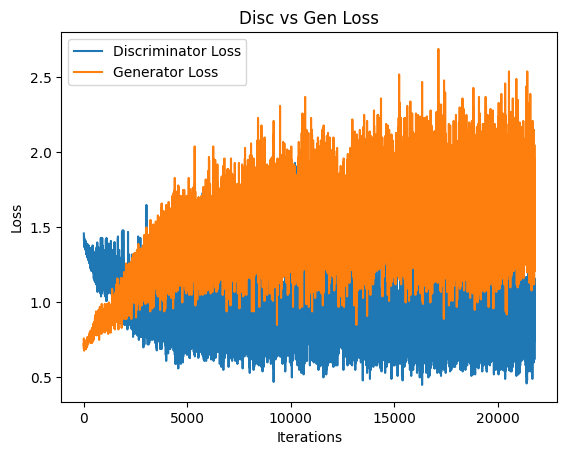

In [659]:
plt.plot(disc_lossi, label='Discriminator Loss')
plt.plot(gen_lossi,  label='Generator Loss')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Disc vs Gen Loss")
plt.legend();

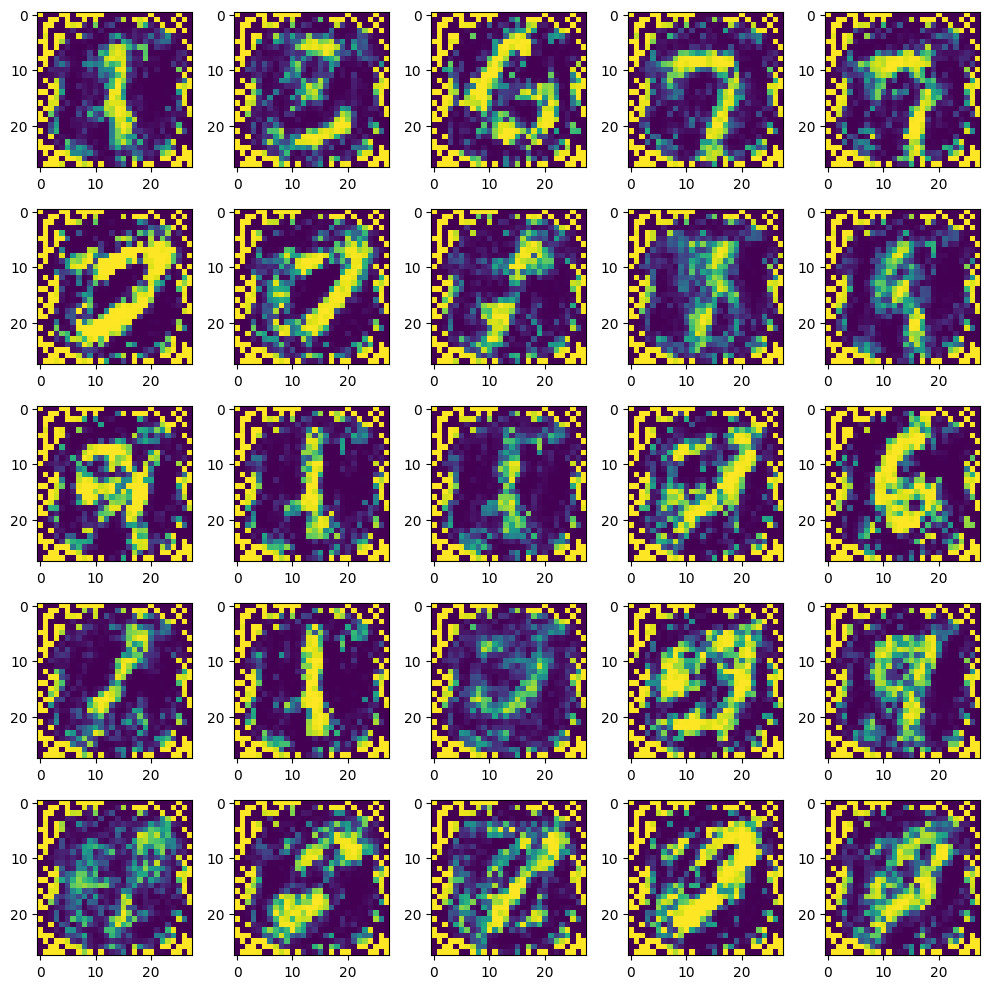

In [660]:
plt.figure(figsize=(10, 10))

for i in range(25):
  plt.subplot(5, 5, i + 1)
  gen.eval()
  plt.imshow(gen(torch.randn((1, INPUT_DIM)).clamp(-1, 1).to(DEVICE)).view((28, 28)).cpu().detach().numpy())

plt.tight_layout()

</br></br>

## DCGAN
---

</br></br>

Now will begin the implementation of the DCGAN.

`DCDiscriminator`:
- Same objective as discriminator, pretty much just a CNN for fake/not-fake binary classification.
- The number of channels through the convolutional layers first starts high and progressively decreases. This enables the discriminator to pick up high level features on each convolutional layer and produce an output label prediction at the end
- Bias is set to false on all conv layers since batch norm takes care of that, batch norm has the tunable params alpha and gamma, where gamma is simply added in the same way a bias would

`DCGenerator`:
- Generates images using transposed comvolutions, and convolutional layers at the end to make sure the output is a 28 x 28 image
- Similar thing with the progressive channel decrease through the tranposed convolutional layers for hierarchical feature learning
- Stride and padding ensure that there is no checkerboard type output that sometimes happens


Input dim is expanded to 100, this enables a more expressive latent space with more possible inputs to produce more varying outputs.

In [665]:
INPUT_DIM = 100

In [666]:
class DCDiscriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.block1 = nn.Sequential(
        nn.Conv2d(1, 128, 4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2)
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(128, 64, 3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2)
    )
    self.block3 = nn.Sequential(
        nn.Conv2d(64, 32, 3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2)
    )
    self.block4 = nn.Sequential(
        nn.Conv2d(32, 16, 3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(0.2)
    )
    self.block5 = nn.Sequential(
        nn.Conv2d(16, 1, 2, stride=2, padding=0, bias=False),
        nn.Dropout(0.2),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = x.view((x.shape[0], -1, 28, 28))
    x1 = self.block1(x)
    x2 = self.block2(x1)
    x3 = self.block3(x2)
    x4 = self.block4(x3)
    x5 = self.block5(x4)

    return x5.view((x5.shape[0], 1))


class DCGenerator(nn.Module):
  def __init__(self):
    super().__init__()

    self.block1 = nn.Sequential(
        nn.ConvTranspose2d(INPUT_DIM, 2048, 3, stride=1, padding=0, bias=False),
        nn.ReLU()
    )
    self.block2 = nn.Sequential(
        nn.ConvTranspose2d(2048, 1024, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(1024),
        nn.ReLU()
    )
    self.block3 = nn.Sequential(
        nn.ConvTranspose2d(1024, 512, 3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )
    self.block4 = nn.Sequential(
        nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )
    self.block5 = nn.Sequential(
        nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )
    self.block6 = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.block7 = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU()
    )
    self.block8 = nn.Sequential(
        nn.Conv2d(32, 16, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(16),
        nn.ReLU()
    )
    self.block9 = nn.Sequential(
        nn.Conv2d(16, 8, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(8),
        nn.ReLU()
    )
    self.block10 = nn.Sequential(
        nn.Conv2d(8, 6, 4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(6),
        nn.ReLU()
    )
    self.block11 = nn.Sequential(
        nn.Conv2d(6, 4, 4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(4),
        nn.ReLU()
    )
    self.block12 = nn.Sequential(
        nn.Conv2d(4, 3, 4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(3),
        nn.ReLU()
    )
    self.block13 = nn.Sequential(
        nn.Conv2d(3, 2, 4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(2),
        nn.ReLU()
    )
    self.block14 = nn.Sequential(
        nn.Conv2d(2, 1, 4, stride=1, padding=0, bias=False),
        nn.Tanh()
    )

  def forward(self, x):
    x  = x.view((x.shape[0], x.shape[1], 1, 1))
    x1 = self.block1(x)
    x2 = self.block2(x1)
    x3 = self.block3(x2)
    x4 = self.block4(x3)
    x5 = self.block5(x4)
    x6 = self.block6(x5)
    x7 = self.block7(x6)
    x8 = self.block8(x7)
    x9 = self.block9(x8)
    x10 = self.block10(x9)
    x11 = self.block11(x10)
    x12 = self.block12(x11)
    x13 = self.block13(x12)
    x14 = self.block14(x13)

    return x14

In [667]:
disc = DCDiscriminator().to(DEVICE)
gen  = DCGenerator().to(DEVICE)

d_optim = torch.optim.SGD(disc.parameters(), lr=LEARNING_RATE)
g_optim = torch.optim.SGD(gen.parameters(),  lr=LEARNING_RATE)

criterion = nn.BCELoss()

</br></br>

## Train DCGAN
---

Standard approach and same functions for DCGAN training

In [668]:
gen_lossi  = []
disc_lossi = []

for epoch in range(EPOCHS):
  print(f"\n\n------------- EPOCH {epoch} -------------")
  g_losses, d_losses = train_epoch()
  gen_lossi.extend(g_losses)
  disc_lossi.extend(d_losses)



------------- EPOCH 0 -------------
ITERATION: 0  |  GEN LOSS: 0.58  |  DISC LOSS: 1.39
ITERATION: 10  |  GEN LOSS: 0.58  |  DISC LOSS: 1.43
ITERATION: 20  |  GEN LOSS: 0.55  |  DISC LOSS: 1.47
ITERATION: 30  |  GEN LOSS: 0.47  |  DISC LOSS: 1.56
ITERATION: 40  |  GEN LOSS: 0.5  |  DISC LOSS: 1.47
ITERATION: 50  |  GEN LOSS: 0.5  |  DISC LOSS: 1.48
ITERATION: 60  |  GEN LOSS: 0.48  |  DISC LOSS: 1.53
ITERATION: 70  |  GEN LOSS: 0.48  |  DISC LOSS: 1.46
ITERATION: 80  |  GEN LOSS: 0.5  |  DISC LOSS: 1.42
ITERATION: 90  |  GEN LOSS: 0.51  |  DISC LOSS: 1.37
ITERATION: 100  |  GEN LOSS: 0.49  |  DISC LOSS: 1.36
ITERATION: 110  |  GEN LOSS: 0.55  |  DISC LOSS: 1.33
ITERATION: 120  |  GEN LOSS: 0.59  |  DISC LOSS: 1.36
ITERATION: 130  |  GEN LOSS: 0.53  |  DISC LOSS: 1.37
ITERATION: 140  |  GEN LOSS: 0.54  |  DISC LOSS: 1.34
ITERATION: 150  |  GEN LOSS: 0.53  |  DISC LOSS: 1.28
ITERATION: 160  |  GEN LOSS: 0.58  |  DISC LOSS: 1.25
ITERATION: 170  |  GEN LOSS: 0.58  |  DISC LOSS: 1.31
ITER

</br></br>

## Evaluate DCGAN
---


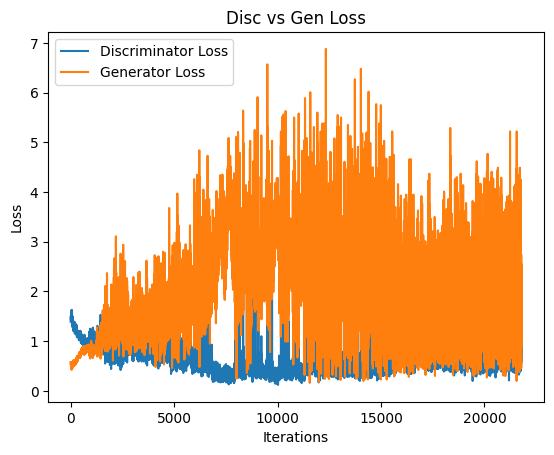

In [669]:
plt.plot(disc_lossi, label='Discriminator Loss')
plt.plot(gen_lossi,  label='Generator Loss')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Disc vs Gen Loss")
plt.legend();

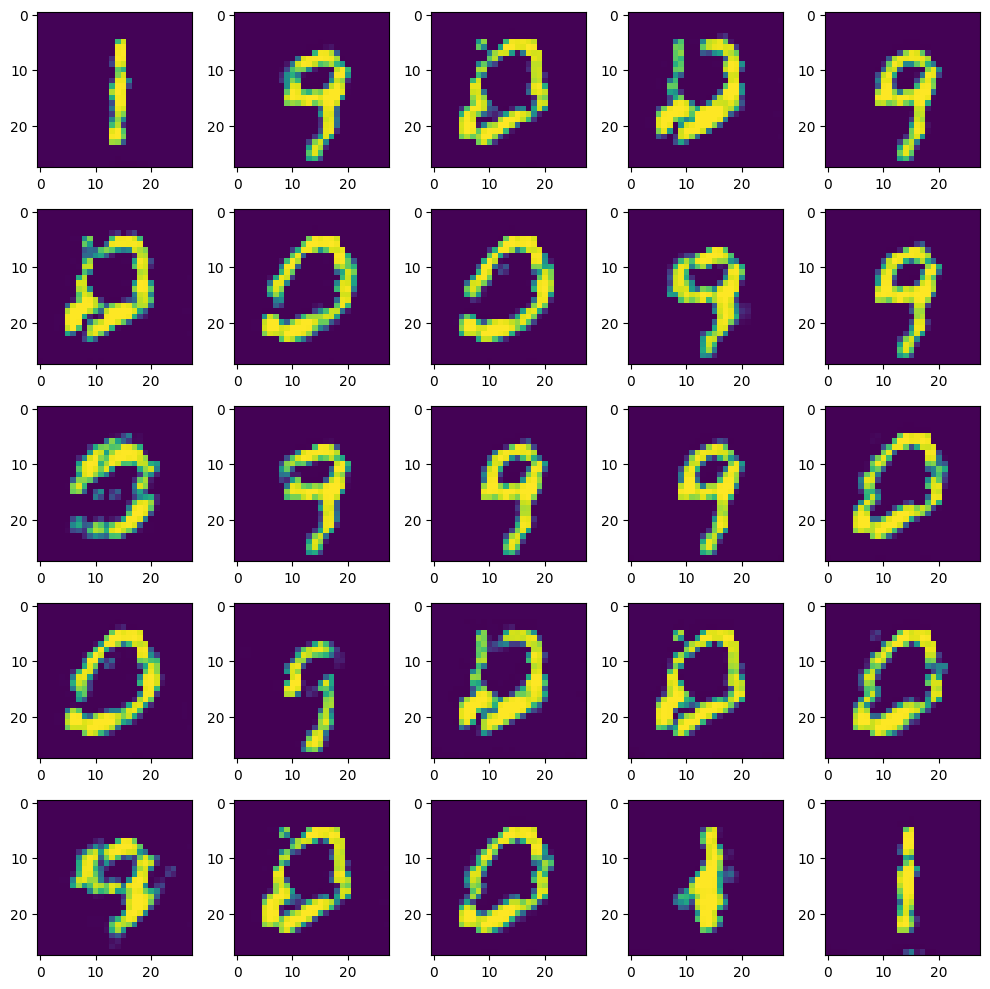

In [670]:
plt.figure(figsize=(10, 10))

for i in range(25):
  plt.subplot(5, 5, i + 1)
  gen.eval()
  plt.imshow(gen(torch.randn((1, INPUT_DIM)).clamp(-1, 1).to(DEVICE)).view((28, 28)).cpu().detach().numpy())

plt.tight_layout()